In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt

import shap
from lime import lime_tabular

from xgboost import XGBRegressor

In [27]:
data = pd.read_csv('../data/stock_data_JNJ.csv')
data['Date'] = pd.to_datetime(data['Date'])
cutoff_date = '2023-09-01'
cutoff_date = pd.to_datetime(cutoff_date)
stock_data = data[data['Date'] <= cutoff_date]
future_data = data[data['Date'] > cutoff_date]

In [28]:
features = stock_data.drop(columns=['Date', 'Adj Close', 'Open']).fillna(method='ffill').fillna(method='bfill')
target = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')

/var/folders/jt/6cptnf497m1b19p6ksf_gz6c0000gn/T/ipykernel_5152/3539445263.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = stock_data.drop(columns=['Date', 'Adj Close', 'Open']).fillna(method='ffill').fillna(method='bfill')
/var/folders/jt/6cptnf497m1b19p6ksf_gz6c0000gn/T/ipykernel_5152/3539445263.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')


In [29]:
# Split the dataset
# Use all but the last entry for training to predict the next day's 'Adj Close'
X_train, X_last = features.iloc[:-1], features.iloc[-1:]
y_train = target.iloc[:-1]

# Adjust the model's parameters for quicker training
model = XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=3)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
future_features = future_data.drop(columns=['Date', 'Adj Close', 'Open'])

In [31]:
X_recent = stock_data.iloc[-1:].drop(columns=['Date', 'Adj Close', 'Open'])  # Adjust columns as needed

predicted_prices = []

# Predict the next day's price using the most recent data
predicted_price = model.predict(X_recent)[0]
predicted_prices.append(predicted_price)

In [32]:
for i in range(9):
    X_future = future_features.iloc[i:i+1]  # Select the features for the current day in the loop
    predicted_price = model.predict(X_future)[0]
    predicted_prices.append(predicted_price)

In [33]:
actual_prices = future_data['Adj Close'][:10]
dates = future_data['Date'][:10]

In [34]:
data = pd.DataFrame({
    'Date': dates,
    'actual price': actual_prices,
    'predicted price': predicted_prices
})

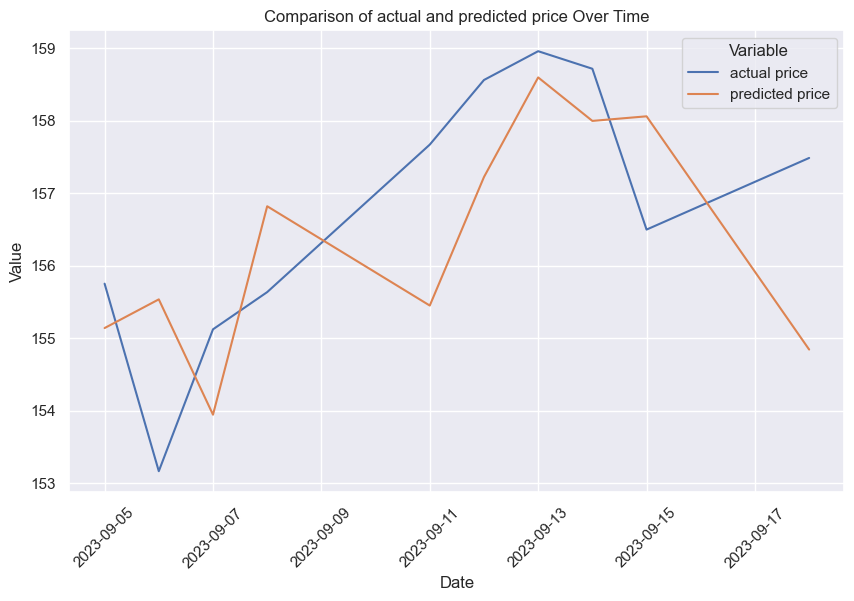

In [35]:
data_long = pd.melt(data, id_vars=['Date'], value_vars=['actual price', 'predicted price'], var_name='Variable', value_name='Value')

# Create the plot
sns.set_theme()  # Set the Seaborn theme
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the data using seaborn lineplot
sns.lineplot(data=data_long, x='Date', y='Value', hue='Variable')

# Customize the plot
plt.title('Comparison of actual and predicted price Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()


In [36]:
rmse = sqrt(mean_squared_error(data['actual price'], data['predicted price']))
print(f'RMSE: {rmse}')

RMSE: 1.6001593164653076


SHAP explanations

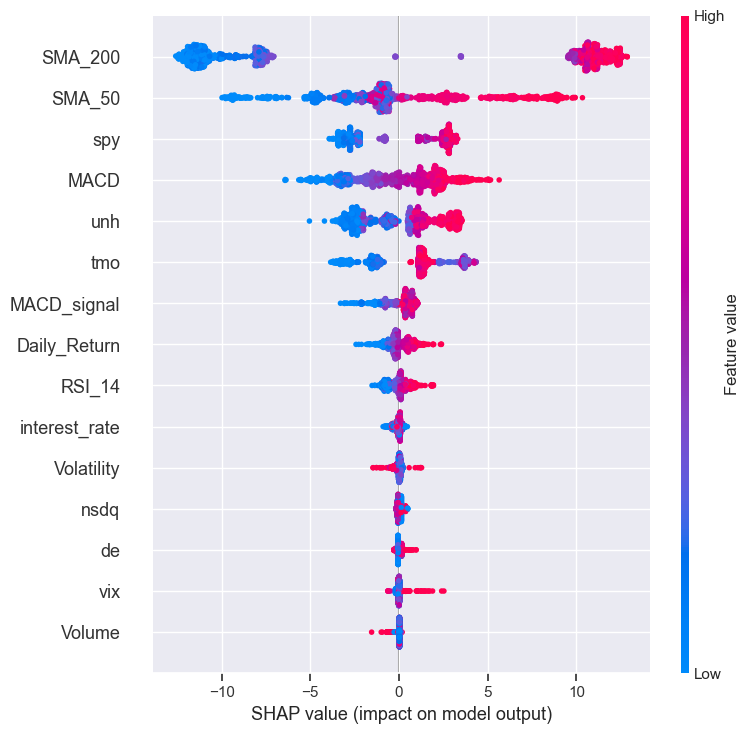

In [37]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

# Plot summary of SHAP values
shap.summary_plot(shap_values, features)

LIME Explanations

In [38]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression'
)

# Function to make predictions from your model
def predict_fn(data):
    return model.predict(data)

# Explain an individual prediction (e.g., the first instance in your dataset)
exp = explainer.explain_instance(data_row=features.iloc[-1].values, predict_fn=predict_fn)

# Visualize the explanation
exp.show_in_notebook(show_table=True)

In [39]:
shap_sum = np.abs(shap_values).mean(axis=0)

# Sort features by importance and select top N
N_top_features = 7  # Choose how many top features to select
top_feature_indices = np.argsort(shap_sum)[-N_top_features:]
top_features = features.columns[top_feature_indices]
print(f"Top {N_top_features} features selected: {top_features}")

Top 7 features selected: Index(['MACD_signal', 'tmo', 'unh', 'MACD', 'spy', 'SMA_50', 'SMA_200'], dtype='object')


In [22]:
X_train_selected = X_train[top_features]
X_future_selected = future_features[top_features]

# Retrain the model using selected features
model_selected = XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=3)
model_selected.fit(X_train_selected, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
# Predict future prices using the feature-selected model
predicted_prices_selected = []
predicted_price_selected = model_selected.predict(X_train_selected.iloc[-1:].values)[0]
predicted_prices_selected.append(predicted_price_selected)

# Predict next 9 days
for i in range(9):
    X_future = X_future_selected.iloc[i:i+1]
    predicted_price_selected = model_selected.predict(X_future)[0]
    predicted_prices_selected.append(predicted_price_selected)

# Create a dataframe to compare actual and predicted prices using the selected-feature model
data_selected = pd.DataFrame({
    'Date': dates,
    'actual price': actual_prices,
    'predicted price (selected)': predicted_prices_selected
})

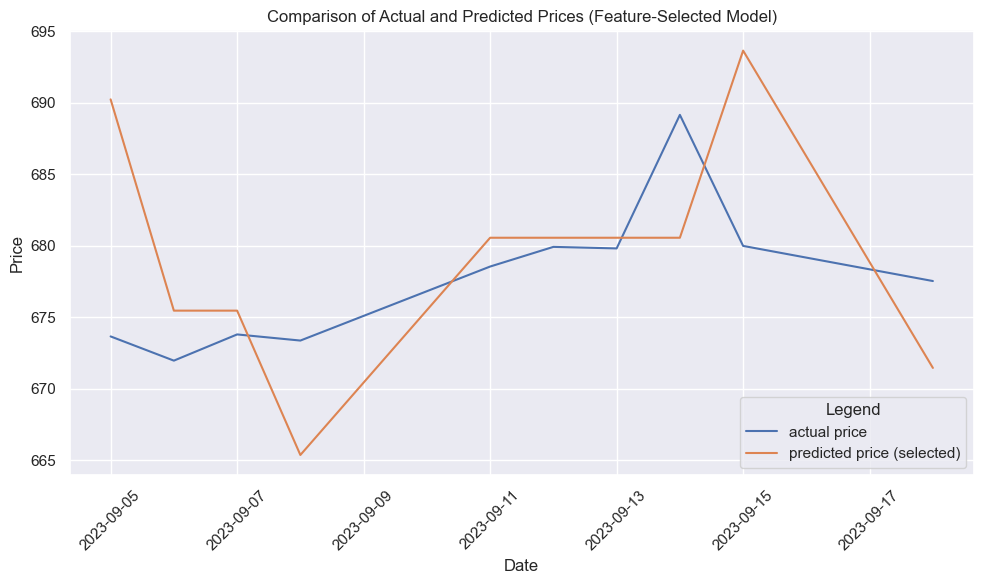

RMSE (Selected Features): 8.10131557662167


In [24]:
# Reshape the data for plotting
data_long_selected = pd.melt(data_selected, id_vars=['Date'], value_vars=['actual price', 'predicted price (selected)'], var_name='Variable', value_name='Value')

# Plot the selected-feature model's predictions vs actual prices
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_long_selected, x='Date', y='Value', hue='Variable')  # Use 'hue' to distinguish between actual and predicted prices

# Customize the plot
plt.title('Comparison of Actual and Predicted Prices (Feature-Selected Model)')
plt.xlabel('Date')
plt.ylabel('Price')

# Rotate the x-axis labels to display dates properly
plt.xticks(rotation=45)

# Show the plot with legend and proper x-axis formatting
plt.legend(title='Legend')
plt.tight_layout()
plt.show()

# Calculate RMSE for the selected-feature model
rmse_selected = sqrt(mean_squared_error(data_selected['actual price'], data_selected['predicted price (selected)']))
print(f'RMSE (Selected Features): {rmse_selected}')